
## This notebook shows how to use Grizli to

Retrieve and pre-process raw CLEAR G102/F105W and 3D-HST G141/F140W observations for a specific CLEAR pointing (GS1).
        
** more comments inbound

These series of notebooks draw heavily from Gabe Brammer's existing grizli notebooks, which are available at https://github.com/gbrammer/grizli/tree/master/examples, but with specific focus for the CLEAR survey.

In [1]:
import grizli
try: 
    from mastquery import query, overlaps
    use_mquery = True
except: 
    from hsaquery import query, overlaps
    use_mquery = False

import os
import numpy as np
from IPython.display import Image
from grizli.pipeline import auto_script
import glob
from glob import glob
import astropy
from grizli.prep import process_direct_grism_visit
from astropy.io import fits


## The paths defined below need to be changed to your own directories.
### the PATH_TO_CATS directory should include the following:
        ###     reference mosaic image (e.g., goodss-F105W-astrodrizzle-v4.3_drz_sci.fits)
        ###     segmentation map       (e.g., Goods_S_plus_seg.fits)
        ###     source catalog         (e.g., goodss-F105W-astrodrizzle-v4.3_drz_sub_plus.cat)
        ###     radec_catalog          (e.g., goodsS_radec.cat)
        ###     3DHST Eazy Catalogs    (e.g., goodss_3dhst.v4.1.cats/*)
### these are all available on the team archive: https://archive.stsci.edu/pub/clear_team/INCOMING/for_hackday/
### the HOME_PATH directory is where the raw data, reduced data, and grizli outputs will be stored


In [2]:
field           = 'GS1'
ref_filter      = 'F105W'

HOME_PATH       = '/Users/rsimons/Desktop/clear/for_hackday/%s'%field
PATH_TO_CATS    = '/Users/rsimons/Desktop/clear/Catalogs'

if not os.path.isdir(HOME_PATH): os.system('mkdir %s'%HOME_PATH)
if not os.path.isdir(HOME_PATH + '/query_results'): os.system('mkdir %s/query_results'%HOME_PATH)

os.chdir(HOME_PATH)


## Run an initial query for all raw G102 data in the ESA archive with a target name that includes the phrase 'GS1' and a proposal ID of 14227 (i.e., GS1 pointing of CLEAR). 

In [3]:
parent = query.run_query(box = None, proposal_id = [14227], instruments=['WFC3/IR', 'ACS/WFC'], 
                         filters = ['G102'], target_name = 'GS1')

## Then, find all overlapping G102 and G141 observations.

Iter #1, N_Patch = 1


 0 j0333m2742 53.24696550387 -27.69263492857333
 target_name 
-------------
GOODS-SOUTH-1
          GS1 

filter j0333m2742          WFC3/IR G102    6   27670.5
filter j0333m2742          WFC3/IR G141    1    4711.7


0

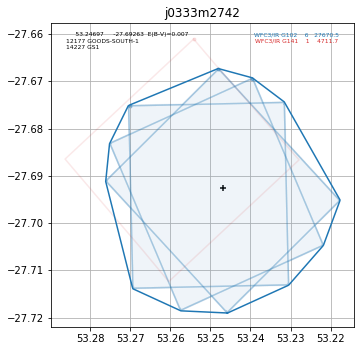

In [4]:
# Finding all overlapping G102 and G141 observations in the archive
tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                              filters=['G102', 'G141'], 
                              instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC'], close=False)

footprint_fits_file = glob('*footprint.fits')[0]
jtargname = footprint_fits_file.strip('_footprint.fits')

fp_fits = fits.open(footprint_fits_file)

overlapping_target_names = set(fp_fits[1].data['target'])
s3_status = os.system('aws s3 ls s3://stpubdata --request-payer requester')

# Move the figure files to $HOME_PATH/query_results/ so that they are not overwritten
os.system('cp %s/%s_footprint.fits %s/query_results/%s_footprint_%s.fits'%(HOME_PATH, jtargname, HOME_PATH, jtargname, 'all_G102_G141'))
os.system('cp %s/%s_footprint.npy %s/query_results/%s_footprint_%s.npy'%(HOME_PATH, jtargname, HOME_PATH, jtargname,  'all_G102_G141'))
os.system('cp %s/%s_footprint.pdf %s/query_results/%s_footprint_%s.pdf'%(HOME_PATH, jtargname, HOME_PATH, jtargname,  'all_G102_G141'))
os.system('cp %s/%s_info.dat %s/query_results/%s_info_%s.dat'%(HOME_PATH, jtargname, HOME_PATH, jtargname,  'all_G102_G141'))


## We now have a list of the target names for the G102 and G141 observations in the ESA archive that overlap with the GS1 pointing of CLEAR. 

### For each target name, search the archive and retrieve all associated RAW grism G102/G141 and direct imaging F098M/F105W/F125W/F140W data.

**For GS1, the retrieval step takes about 30 minutes to run and requires 1.9 GB of space.


Iter #1, N_Patch = 1


 0 j0333m2742 53.24696550387 -27.69263492857333
target_name
-----------
        GS1 

filter j0333m2742         WFC3/IR F105W    6    3185.2
filter j0333m2742          WFC3/IR G102    6   27670.5
gunzip icxt08e6q_raw.fits.gz  # status="0"
gunzip icxt12r2q_raw.fits.gz  # status="0"
gunzip icxt12qvq_raw.fits.gz  # status="0"
gunzip icxt07e1q_raw.fits.gz  # status="0"
gunzip icxt09f7q_raw.fits.gz  # status="0"
gunzip icxt09f0q_raw.fits.gz  # status="0"
gunzip icxt08e7q_raw.fits.gz  # status="0"
gunzip icxt07dwq_raw.fits.gz  # status="0"
gunzip icxt10deq_raw.fits.gz  # status="0"
gunzip icxt10dbq_raw.fits.gz  # status="0"
gunzip icxt11qiq_raw.fits.gz  # status="0"
gunzip icxt11qnq_raw.fits.gz  # status="0"
gunzip icxt10dhq_raw.fits.gz  # status="0"
gunzip icxt12qzq_raw.fits.gz  # status="0"
gunzip icxt07dzq_raw.fits.gz  # status="0"
gunzip icxt10diq_raw.fits.gz  # status="0"
gunzip icxt11qhq_raw.fits.gz  # status="0"
gunzip icxt11qpq_raw.fits.gz  # status="0"
gunzip 

Iter #1, N_Patch = 1


 0 j0333m2742 53.24696550387 -27.69263492857333
 target_name 
-------------
GOODS-SOUTH-1 

filter j0333m2742         WFC3/IR F140W    1     811.7
filter j0333m2742          WFC3/IR G141    1    4711.7
gunzip ibhj01jbq_raw.fits.gz  # status="0"
gunzip ibhj01j9q_raw.fits.gz  # status="0"
gunzip ibhj01ioq_raw.fits.gz  # status="0"
gunzip ibhj01j4q_raw.fits.gz  # status="0"
gunzip ibhj01ivq_raw.fits.gz  # status="0"
gunzip ibhj01iqq_raw.fits.gz  # status="0"
gunzip ibhj01j2q_raw.fits.gz  # status="0"
gunzip ibhj01ixq_raw.fits.gz  # status="0"
Calib: IDCTAB=iref$w3m18525i_idc.fits
/Users/rsimons/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/Users/rsimons/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/Users/rsimons/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/Users/rsimons/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m1

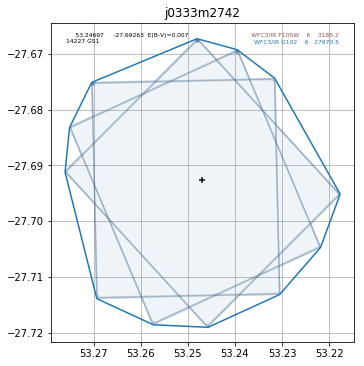

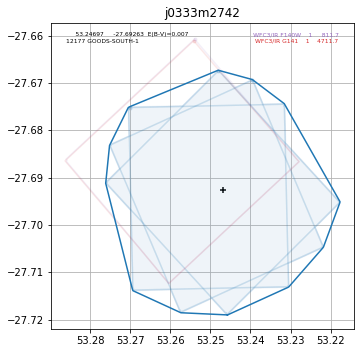

In [5]:
for t, targ_name in enumerate(overlapping_target_names):


    if use_mquery:
        extra = {'target_name':targ_name}
    else:
        extra = query.DEFAULT_EXTRA.copy()
        extra += ["TARGET.TARGET_NAME LIKE '%s'"%targ_name]
    
    # search the ESA archive for overlapping grism and direct imaging observations with that target name
    tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                                  filters=['G102', 'G141', 'F098M', 'F105W', 'F125W', 'F140W'], 
                                  instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC'], 
                                  extra=extra, close=False)
    if True:
        s3_status = os.system('aws s3 ls s3://stpubdata --request-payer requester')

        #retrieve the raw data products
        auto_script.fetch_files(field_root=jtargname, HOME_PATH=HOME_PATH, remove_bad=True, 
                                reprocess_parallel=True, s3_sync=(s3_status == 0))

    # Move the figure files to $HOME_PATH/query_results/ so that they are not overwritten
    os.system('mv %s/%s_footprint.fits %s/query_results/%s_footprint_%s.fits'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))
    os.system('mv %s/%s_footprint.npy %s/query_results/%s_footprint_%s.npy'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))
    os.system('mv %s/%s_footprint.pdf %s/query_results/%s_footprint_%s.pdf'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))
    os.system('mv %s/%s_info.dat %s/query_results/%s_info_%s.dat'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))

    os.chdir(HOME_PATH)

In [ ]:
# PATH_TO_RAW and PATH_TO_PREP are created in the previous steps
PATH_TO_RAW     = glob(HOME_PATH + '/*/RAW')[0]
PATH_TO_PREP    = glob(HOME_PATH + '/*/PREP')[0]

os.chdir(PATH_TO_PREP)
files = glob('%s/*flt.fits'%PATH_TO_RAW)
info = grizli.utils.get_flt_info(files)
visits, filters = grizli.utils.parse_flt_files(info=info, uniquename=True)


In [ ]:
if True:
    product_names = np.array([visit['product'] for visit in visits])
    filter_names = np.array([visit['product'].split('-')[-1] for visit in visits])
    basenames = np.array([visit['product'].split('.')[0]+'.0' for visit in visits])

    for ref_grism, ref_filter in [('G102', 'F105W'), ('G141', 'F140W')]:
        print(ref_grism, ref_filter)

        for v, visit in enumerate(visits):
            product = product_names[v]
            basename = basenames[v]
            filt1 = filter_names[v]
            field_in_contest = basename.split('-')[0]
            if (ref_filter.lower() == filt1.lower()):
                #Found a direct image, now search for grism counterpart
                grism_index= np.where((basenames == basename) & (filter_names == ref_grism.lower()))[0][0]
                if 'N' in field.upper(): radec_catalog = PATH_TO_CATS + '/old_radeccats/goodsN_radec.cat'
                if 'S' in field.upper(): radec_catalog = PATH_TO_CATS + '/old_radeccats/goodsS_radec.cat'                    
                print (field_in_contest, visits[grism_index])
                #status = process_direct_grism_visit(direct = visit,
                #                                    grism = visits[grism_index],
                #                                    radec = radec_catalog, 
                #                                    align_mag_limits = [14, 23])



## Astrometric correction

In [ ]:
os.chdir(PATH_TO_PREP)
!cat gs1-cxt-09-227.0-f105w_wcs.log
Image(filename = PATH_TO_PREP + '/gs1-cxt-09-227.0-f105w_wcs.png', width = 600, height = 600)

## Grism sky subtraction

In [ ]:
os.chdir(PATH_TO_PREP)
Image(filename = PATH_TO_PREP + '/gs1-cxt-09-227.0-g102_column.png', width = 600, height = 600)